In [ ]:
!pip install langchain_community langchain langgraph langchain-openai openai

In [ ]:
import getpass
import os

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

In [ ]:
from typing import List
from pydantic import BaseModel
from pydantic import Field

class CorrectionSchema(BaseModel):
    start_index: int = Field(..., description="The starting index of the text where the correction begins.")
    end_index: int = Field(..., description="The ending index of the text where the correction ends.")
    correction: str = Field(..., description="The suggested correction for the specified text segment.")
    explanation: str = Field(..., description="Explanation of why the correction is necessary.")

class LogicalRelationSchema(BaseModel):
    sentence: str = Field(..., description="The sentence being analyzed for logical relationships.")
    relation: str = Field(..., description="The type of logical relationship identified (e.g., cause-effect, contrast).")
    confidence: float = Field(..., description="The confidence score of the identified relationship, between 0 and 1.")

class ConnectorSuggestionSchema(BaseModel):
    connector: str = Field(..., description="The suggested logical connector to enhance the coherence of the text.")
    position: int = Field(..., description="The position in the text where the connector should be inserted.")
    relation_type: str = Field(..., description="The type of logical relationship that the connector is addressing.")

In [ ]:
class LogicalRelationsResponseSchema(BaseModel):
  logical_relations: List[LogicalRelationSchema] = Field(..., description="The suggested logical relations for the connectors in the text")

class ConnectorSuggestionResponseSchema(BaseModel):
  connector_suggestions: List[ConnectorSuggestionSchema] = Field(..., description="The suggested connectors for the text")

class TextWithConnectorsResponseSchema(BaseModel):
  text_with_connectors: str = Field(..., description="The text with the suggested connectors")

class FluencyCorrectionsResponseSchema(BaseModel):
  fluency_corrections: List[CorrectionSchema] = Field(..., description="The suggested fluency corrections for the text")

class FinalTextResponseSchema(BaseModel):
  final_text: str = Field(..., description="The final text")

class FinalCheckResponseSchema(BaseModel):
  final_check: str = Field(..., description="The final check to evaluate if the text passes all the criteria about connectors. You must only answer 'yes' or 'no' in lower case"),

In [ ]:
from typing import Dict, TypedDict, Optional
class GraphState(TypedDict):
    text: str
    lang: str

    logical_relations: List[LogicalRelationSchema]
    connector_suggestions: List[ConnectorSuggestionSchema]

    text_with_connectors: str

    fluency_corrections: List[CorrectionSchema]
    final_check: str
    final_text: str

In [ ]:
from langgraph.graph import StateGraph
workflow = StateGraph(GraphState)

In [ ]:
from langchain_openai import ChatOpenAI
from langchain.schema import (
       AIMessage,
       HumanMessage,
       SystemMessage
  )

llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.7)

In [ ]:
from langchain_core.output_parsers import JsonOutputParser
def identify_logical_relations(state):
    json_parser = JsonOutputParser(pydantic_object=LogicalRelationsResponseSchema)

    messages = [
        SystemMessage(content=f"You are a logical relation identifier for {state['lang']} texts."),
        HumanMessage(content=f"""Please analyze the following text and identify the logical relations between sentences:

        {state['text']}

        The relation must be only one word like cause-effect, contrast, addition and so forth.

        Ensure your response follows the format and requirements specified in {json_parser.get_format_instructions()}.
        """)
    ]

    result = llm.invoke(messages)

    parsed_result = json_parser.parse(result.content)

    print(f"STEP 1: {parsed_result}")

    return {
        "logical_relations": parsed_result["logical_relations"]
    }

In [ ]:
def suggest_connectors(state):
    json_parser = JsonOutputParser(pydantic_object=ConnectorSuggestionResponseSchema)

    logical_relations = state["logical_relations"]

    messages = [
        SystemMessage(content=f"You are a connector suggester for {state['lang']} texts."),
        HumanMessage(content=f"""Based on the following logical relations between sentences, please suggest appropriate connectors to improve the coherence of the text:

        Logical Relations: {logical_relations}

        Ensure your response follows the format and requirements specified in {json_parser.get_format_instructions()}.
        """)
    ]

    result = llm.invoke(messages)

    parsed_result = json_parser.parse(result.content)

    print(f"STEP 2: {parsed_result}")

    return {
        "connector_suggestions": parsed_result["connector_suggestions"]
    }

In [ ]:
def apply_connectors_to_text(state):
    json_parser = JsonOutputParser(pydantic_object=TextWithConnectorsResponseSchema)

    original_text = state["text"]
    connector_suggestions = state["connector_suggestions"]

    messages = [
        SystemMessage(content=f"You are a text enhancer for {state['lang']} texts."),
        HumanMessage(content=f"""Based on the following connector suggestions, please return the text with the connectors added in the appropriate places:

        Original Text: {original_text}
        Connector Suggestions: {connector_suggestions}

        Ensure your response follows the format and requirements specified in {json_parser.get_format_instructions()}.
        """)
    ]

    result = llm.invoke(messages)

    parsed_result = json_parser.parse(result.content)

    print(f"STEP 3: {parsed_result}")

    return {
        "text_with_connectors": parsed_result["text_with_connectors"]
    }


In [ ]:
def get_fluency_corrections(state):
    json_parser = JsonOutputParser(pydantic_object=FluencyCorrectionsResponseSchema)

    text_with_connectors = state["text_with_connectors"]

    messages = [
        SystemMessage(content=f"You are a fluency and naturalness improver for {state['lang']} texts."),
        HumanMessage(content=f"""Please analyze the following text and suggest any necessary corrections to improve the fluency and naturalness:

        {text_with_connectors}

        Ensure your response follows the format and requirements specified in {json_parser.get_format_instructions()}.
        """)
    ]

    result = llm.invoke(messages)

    parsed_result = json_parser.parse(result.content)

    print(f"STEP 4: {parsed_result}")

    return {
        "fluency_corrections": parsed_result["fluency_corrections"]
    }

In [ ]:
def generate_final_text(state):
    json_parser = JsonOutputParser(pydantic_object=FinalTextResponseSchema)

    text_with_connectors = state["text_with_connectors"]
    fluency_corrections = state["fluency_corrections"]

    messages = [
        SystemMessage(content=f"You are a text editor for {state['lang']} texts."),
        HumanMessage(content=f"""Please apply the following fluency corrections to the text and return the final text:

        Text with Connectors: {text_with_connectors}
        Fluency Corrections: {fluency_corrections}

        Ensure your response follows the format and requirements specified in {json_parser.get_format_instructions()}.
        """)
    ]

    result = llm.invoke(messages)

    parsed_result = json_parser.parse(result.content)

    print(f"STEP 5: {parsed_result}")

    return {
        "final_text": parsed_result["final_text"]
    }

In [ ]:
def perform_final_check(state):
    json_parser = JsonOutputParser(pydantic_object=FinalCheckResponseSchema)

    final_text = state["final_text"]

    messages = [
        SystemMessage(content=f"You are a text verifier for {state['lang']} texts."),
        HumanMessage(content=f"""Please evaluate if the following text meets all the criteria regarding the use of logical connectors. Answer 'yes' if it passes all criteria and 'no' if it does not. The criteria are:

        1. **Semantic correctness**: Ensure that the connectors used reflect the correct logical relationships between sentences (e.g., 'however' should not be used for cause-effect).

        2. **Coherence and fluency**: Ensure that the connectors do not disrupt the natural flow of the text. Transitions between sentences must be smooth and logical.

        3. **Proper positioning**: Check that the connectors are positioned correctly, typically at the start of a sentence or between two connected ideas.

        4. **No redundancy**: Verify that there are no redundant or unnecessary connectors. Do not use multiple connectors that express the same relationship.

        Final Text: {final_text}

        Ensure your response follows the format and requirements specified in {json_parser.get_format_instructions()}. Answer only 'yes' or 'no' in lowercase.
        """)
    ]

    result = llm.invoke(messages)

    parsed_result = json_parser.parse(result.content)

    print(f"STEP 6 - DECISION: {parsed_result}")

    return {
        "final_check": parsed_result["final_check"]
    }

In [ ]:
def decide_to_finish(state: GraphState):

    final_decision = state["final_check"]

    if final_decision == "yes":
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        return "no"

In [ ]:
from langgraph.graph import END

workflow.add_node("identify_logical_relations", identify_logical_relations)
workflow.add_node("suggest_connectors", suggest_connectors)
workflow.add_node("apply_connectors_to_text", apply_connectors_to_text)
workflow.add_node("get_fluency_corrections", get_fluency_corrections)
workflow.add_node("generate_final_text", generate_final_text)
workflow.add_node("perform_final_check", perform_final_check)

workflow.set_entry_point("identify_logical_relations")
workflow.add_edge('identify_logical_relations', "suggest_connectors")
workflow.add_edge('suggest_connectors', "apply_connectors_to_text")
workflow.add_edge('apply_connectors_to_text', "get_fluency_corrections")
workflow.add_edge('get_fluency_corrections', "generate_final_text")
workflow.add_edge('generate_final_text', "perform_final_check")


workflow.add_conditional_edges(
    "perform_final_check",
    decide_to_finish,
    {
        "end": END,
        "no": "generate_final_text",
    },
)

In [ ]:
app = workflow.compile()

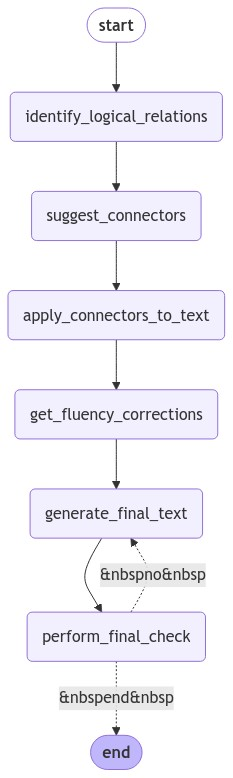

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
inputs = {
    "text": """
    La empresa presentó sus resultados financieros al cierre del tercer trimestre. Las cifras mostraron un incremento significativo en los ingresos brutos.
    El equipo directivo se reunió para discutir estrategias futuras. Los inversores expresaron su interés en las nuevas iniciativas de expansión.
    El mercado respondió con un leve aumento en el valor de las acciones. La compañía está planeando una reestructuración de sus operaciones.
    El objetivo es mejorar la eficiencia y reducir costos operativos. Los empleados fueron informados sobre los posibles cambios en la estructura organizativa.
    La dirección revisará los procesos internos para optimizar la productividad. Las proyecciones indican un crecimiento sostenido en los próximos años.
    El departamento de marketing está evaluando nuevas oportunidades para aumentar la participación en el mercado global.
    """,
    "lang": "es"}

result = app.invoke(inputs)

STEP 1: {'logical_relations': [{'sentence': 'La empresa presentó sus resultados financieros al cierre del tercer trimestre.', 'relation': 'addition', 'confidence': 0.9}, {'sentence': 'Las cifras mostraron un incremento significativo en los ingresos brutos.', 'relation': 'cause-effect', 'confidence': 0.85}, {'sentence': 'El equipo directivo se reunió para discutir estrategias futuras.', 'relation': 'addition', 'confidence': 0.9}, {'sentence': 'Los inversores expresaron su interés en las nuevas iniciativas de expansión.', 'relation': 'cause-effect', 'confidence': 0.8}, {'sentence': 'El mercado respondió con un leve aumento en el valor de las acciones.', 'relation': 'cause-effect', 'confidence': 0.85}, {'sentence': 'La compañía está planeando una reestructuración de sus operaciones.', 'relation': 'addition', 'confidence': 0.9}, {'sentence': 'El objetivo es mejorar la eficiencia y reducir costos operativos.', 'relation': 'cause-effect', 'confidence': 0.9}, {'sentence': 'Los empleados fuero

/usr/local/lib/python3.10/dist-packages/pydantic/json_schema.py:2179: PydanticJsonSchemaWarning: Default value (FieldInfo(annotation=NoneType, required=True, description="The final check to evaluate if the text passes all the criteria about connectors. You must only answer 'yes' or 'no' in lower case"),) is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)


STEP 6 - DECISION: {'final_check': 'yes'}
---DECISION: FINISH---


In [ ]:
result

{'text': '\n    La empresa presentó sus resultados financieros al cierre del tercer trimestre. Las cifras mostraron un incremento significativo en los ingresos brutos. \n    El equipo directivo se reunió para discutir estrategias futuras. Los inversores expresaron su interés en las nuevas iniciativas de expansión. \n    El mercado respondió con un leve aumento en el valor de las acciones. La compañía está planeando una reestructuración de sus operaciones. \n    El objetivo es mejorar la eficiencia y reducir costos operativos. Los empleados fueron informados sobre los posibles cambios en la estructura organizativa. \n    La dirección revisará los procesos internos para optimizar la productividad. Las proyecciones indican un crecimiento sostenido en los próximos años. \n    El departamento de marketing está evaluando nuevas oportunidades para aumentar la participación en el mercado global.\n    ',
 'lang': 'es',
 'logical_relations': [{'sentence': 'La empresa presentó sus resultados fina